# Training Potts Models with Contrastive Divergence for Protein Design

This notebook contains the "Nice to haves" for the project.

In [ ]:
!git clone https://github.com/igemto-drylab/CSBERG-ML.git
%cd CSBERG-ML
from util import *
import tqdm.notebook as tq
%cd ..

In [ ]:
plt.rcParams['figure.dpi'] = 350

In [ ]:
!git clone https://github.com/ranganathanlab/bmDCA.git

In [ ]:
!sudo apt-get update
!sudo apt-get install git gcc g++ automake autoconf pkg-config \
  libarmadillo-dev libopenblas-dev libarpack++2-dev

In [ ]:
%cd bmDCA
!bash autogen.sh --prefix=/usr/local && \
%cd ..

In [ ]:
%%shell
cd bmDCA
make -j4 && \
make install
cd ..

In [ ]:
!mkdir results

In [ ]:
%cd /content

In [1]:
import numpy as np
import torch
import torch.nn as nn
import tqdm.notebook as tq
import random

from torch import optim
from torch.utils.data import DataLoader, Dataset
from util import *

In [2]:
class GREMLIN(torch.nn.Module):
    def __init__(self,L,A):
        super(GREMLIN, self).__init__()
        self.W0 = torch.nn.Parameter(torch.zeros(L*A,L*A), requires_grad=True)
        self.b0 = torch.nn.Parameter(torch.zeros(L*A), requires_grad=True)
        self.MASK = (1.0 -torch.eye(L*A)).to(device)

    def forward(self, X):
        X = X.reshape(-1,L*A)
        W = (self.W0+self.W0)/2.0 * self.MASK
   
        MSA_pred = (X.mm(W)+self.b0).reshape(-1,L,A)
        loss = torch.sum(- msa * F.log_softmax(MSA_pred, -1))
        L2_w = torch.square(W).sum() * 0.01 * 0.5 *L*A
        L2_b = torch.square(self.b0).sum() * 0.01
        loss = loss + L2_w + L2_b
        return loss

class Model(torch.nn.Module):
    def __init__(self,L,A):
        super(Model, self).__init__()
        self.GREMLIN_ = GREMLIN(L,A)
    
    def forward(self,X):
        loss = self.GREMLIN_(X)
        return loss

In [3]:
def read_fasta(fname, onehot=True):
    seqs = []
    seq_list = []
    s = ""
    with open(fname) as f:
        line = f.readline()
        while line:
            if line.startswith(">"):
                if s != "":
                    seqs.append(s)
                s = ""
            elif len(line) > 0:
                s += line.strip()
            line = f.readline()
        seqs.append(s)
        seq_list.append(list(s))
    if onehot:
        return get_X(seqs)
    else:
        return np.array(seqs)
        

def read_fasta_seqs(fname):
    seqs = []
    s = ""
    with open(fname) as f:
        line = f.readline()
        while line:
            if line.startswith(">"):
                if s != "":
                    seqs.append(list(s))
                s = ""
            elif len(line) > 0:
                s += line.strip()
            line = f.readline()
        seqs.append(list(s))
    return np.array(seqs)

In [4]:
def trim_seqs(seqs, save_name):
    """
    seqs: sequences (list of letters not one-hot encoded)
    save_name: output fasta filename
    returns: mask (1 for kept positions, 0 for discarded positions)
    """
    mask = np.zeros(len(seqs[0]), dtype=np.bool)
    for i in range(len(seqs[0])):
        gaps = 0
        for s in seqs:
            if s[i] == '-':
                gaps += 1
        if gaps/len(seqs) < 0.67:   # keep positions where less than 2/3rd are gaps
            mask[i] = True
    seqs = seqs[:,mask]

    towrite = ""
    for i in range(len(seqs)):
        if sum(seqs[i][100:] == "-") < 50:  # don't take sequences with many gaps
            towrite += ">{}\n".format(i)
            seq = "".join(seqs[i][:]) + "\n"
            towrite += seq.upper()   
    with open(save_name,'w') as f:
        f.write(towrite)
    return mask

In [5]:
seqs = read_fasta_seqs("lcc_pfam.txt")
mask = trim_seqs(seqs, "lcc_short.fasta")

/Users/syedather/opt/anaconda3/envs/jpy3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


In [6]:
i = 0
j = 0
trim2ali = {} # maps index of trimmed sequence to index of aligned sequence
while j < len(mask):
    if mask[j] == 1:
        trim2ali[i] = j
        i += 1
    j += 1
print(trim2ali)

{0: 165, 1: 166, 2: 167, 3: 168, 4: 169, 5: 170, 6: 172, 7: 173, 8: 174, 9: 175, 10: 177, 11: 179, 12: 181, 13: 182, 14: 183, 15: 184, 16: 192, 17: 193, 18: 194, 19: 195, 20: 197, 21: 200, 22: 205, 23: 213, 24: 221, 25: 231, 26: 241, 27: 250, 28: 260, 29: 269, 30: 271, 31: 272, 32: 290, 33: 291, 34: 295, 35: 299, 36: 304, 37: 309, 38: 317, 39: 322, 40: 328, 41: 338, 42: 345, 43: 351, 44: 360, 45: 366, 46: 379, 47: 389, 48: 392, 49: 396, 50: 404, 51: 414, 52: 418, 53: 427, 54: 431, 55: 435, 56: 439, 57: 440, 58: 441, 59: 502, 60: 503, 61: 505, 62: 509, 63: 513, 64: 517, 65: 520, 66: 524, 67: 529, 68: 534, 69: 540, 70: 545, 71: 551, 72: 561, 73: 569, 74: 574, 75: 583, 76: 591, 77: 598, 78: 608, 79: 617, 80: 626, 81: 633, 82: 641, 83: 648, 84: 652, 85: 656, 86: 659, 87: 660, 88: 694, 89: 698, 90: 702, 91: 706, 92: 710, 93: 716, 94: 722, 95: 730, 96: 737, 97: 744, 98: 751, 99: 759, 100: 769, 101: 783, 102: 798, 103: 809, 104: 816, 105: 822, 106: 829, 107: 832, 108: 836, 109: 838, 110: 848,

In [7]:
# map index of aligned sequence to residue index on the protein structure
aligned = """------------------------------------------------------------
------------------------------------------------------------
-----------------------------------------------AGTV------Y-Y
-PTNAG------GTVG-A--I----A-------I-------V---------P--------
-G--------Y---------T--------A-RQ-----------------SS---I---K
----W----W-------G----P-----R---------L------A-----S--------
H-----G------------F---------V--V---I-------T---------I---D-
-------T---N---S---TLD--------------------------------------
----------------------QP-S---S---R---S--S---Q----Q----M-----
A----A-----L---------R-------Q----V--------A-------S------L-
--------N---------------------------------------G---T---S--S
S-----------------------------------------------------------
----------P------I------Y------G-------K---------V----------
---D--------------T----------A------R-----M------G--V---M-G-
--------W---S-------M-----------G--------G---------G------G-
--------S-----------L-------------I-----------S-------------
---A----------------A---------------N---------------N-------
--P---------------S---------------L--------------K----------
--A----------A-------------A---------P---------Q------A-P---
------------------------------------------------------------
---W--D--S-----S----T-----N-----F------S-----S------V-------
-T--------V------P-----T-------L---I-----F--A-C---E--N------
--D--S---I---A--P----V---N--S------------------------S-A-L--
-PI--------Y-------D--------S------M--------------------S---
-------R------------------N-----------A----------K----------
Q------F--------L-------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
-----------------EINGGSHSCANSGNSNQALIGKKGVAWMKRFM-----------
------------------------------------------------------------
--------------------------------""".replace('\n','')

short = """--AGTV----YYPTNAGTVGAIAIVPGYTARQSSIKWWGPRLASHGFVV
ITIDTNSTLDQPSSRSSQQMAALRQVASLN----GTSSS-------PIYGKVDTARMGVM
GWSMGGGGSLISAANNPSLKAAAPQAP---WDSSTNFSSVTVPTLIFACENDSIAPVNSS
ALIYDSM-SRNAKQFL---------------------------------------EIN""".replace('\n','')

protein = """MNFPRASRLMQAAVLGGLMAVSAAATAQTNPYARGPNPTAASLEASAGPFTVRSFTVSRPS
GYGAGTVYYPTNAGGTVGAIAIVPGYTARQSSIKWWGPRLASHGFVVITIDTNSTLDQPS
SRSSQQMAALRQVASLNGTSSSPIYGKVDTARMGVMGWSMGGGGSLISAANNPSLKAAAP
QAPWDSSTNFSSVTVPTLIFACENDSIAPVNSSALPIYDSMSRNAKQFLEINGGSHSCAN
SGNSNQALIGKKGVAWMKRFMDNDTRYSTFACENPNSTRVSDFRTANCSLEHHHHHH""".replace('\n','')

ali2prot = {}
i = 0
j = 65 - 1
while i < len(aligned):
    if aligned[i] != "-":
        if aligned[i] == protein[j]:
            ali2prot[i] = j + 1
            j += 1
        else:
            raise KeyError
    i += 1
print(ali2prot)

{167: 65, 168: 66, 169: 67, 170: 68, 177: 69, 179: 70, 181: 71, 182: 72, 183: 73, 184: 74, 185: 75, 192: 76, 193: 77, 194: 78, 195: 79, 197: 80, 200: 81, 205: 82, 213: 83, 221: 84, 231: 85, 241: 86, 250: 87, 260: 88, 269: 89, 271: 90, 272: 91, 290: 92, 291: 93, 295: 94, 299: 95, 304: 96, 309: 97, 317: 98, 322: 99, 328: 100, 338: 101, 345: 102, 351: 103, 360: 104, 366: 105, 379: 106, 389: 107, 392: 108, 396: 109, 404: 110, 414: 111, 418: 112, 427: 113, 431: 114, 435: 115, 439: 116, 440: 117, 441: 118, 502: 119, 503: 120, 505: 121, 509: 122, 513: 123, 517: 124, 520: 125, 524: 126, 529: 127, 534: 128, 540: 129, 545: 130, 551: 131, 561: 132, 569: 133, 574: 134, 583: 135, 591: 136, 598: 137, 608: 138, 648: 139, 652: 140, 656: 141, 659: 142, 660: 143, 730: 144, 737: 145, 744: 146, 751: 147, 759: 148, 769: 149, 783: 150, 798: 151, 809: 152, 816: 153, 822: 154, 829: 155, 832: 156, 836: 157, 838: 158, 848: 159, 852: 160, 860: 161, 872: 162, 881: 163, 891: 164, 898: 165, 908: 166, 920: 167, 934:

In [8]:
idx = np.array(list(trim2ali.values())).astype(np.int)
ali = np.array(list(aligned))
print("".join(list(ali[idx])))

--AGTV----YYPTNAGTVGAIAIVPGYTARQSSIKWWGPRLASHGFVVITIDTNSTLDQPSSRSSQQMAALRQVASLN----GTSSS-------PIYGKVDTARMGVMGWSMGGGGSLISAANNPSLKAAAPQAP---WDSSTNFSSVTVPTLIFACENDSIAPVNSSALIYDSM-SRNAKQFL---------------------------------------EIN


/Users/syedather/opt/anaconda3/envs/jpy3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [23]:
msa = read_fasta("lcc_short.fasta")
print(msa.shape)
N, L, A = msa.shape
msa = torch.from_numpy(msa)
msa = msa.type(torch.FloatTensor).to(device)

(15028, 227, 21)


In [10]:
def map_index(l):
    """
    l: list of indices of the trimmed sequences
    returns: corresponding protein structure indices
    """
    idx = []
    for i in l:
        try:
            idx.append(ali2prot[trim2ali[i]])
        except KeyError:
            idx.append(0)
    return idx

In [11]:
beta_carbons = []
with open("CSBERG-ML/1gfp_h.pdb", 'r') as f:
    line = f.readline()
    line = f.readline()
    while line:
        data = line.split()
        if data[2] == 'CB' or data[2] == 'HA1':
            beta_carbons.append([float(data[6]), float(data[7]), float(data[8])])
        line = f.readline()

coords = np.array(beta_carbons[1:])
dists = np.zeros((len(coords), len(coords)))
for i, curr in enumerate(coords):
    dists[:,i] = np.linalg.norm(coords - curr, axis=1)

In [12]:
def get_precision(L2, L5):
    for l in [L2, L5]:
        p = 0
        a = map_index(list(l.flatten()))
        a = np.array(a).reshape(-1,2) - 29 # structure index starts at 29
        for row in a:
            if row[0] != 0 and row[1] != 0:
                if dists[row[0], row[1]] < 8.0:
                    p += 1
        print(p/len(L2))

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Model(L, A).to(device)
learning_rate = 0.1*np.log(N)/L
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  0%|          | 0/100 [00:00<?, ?it/s]

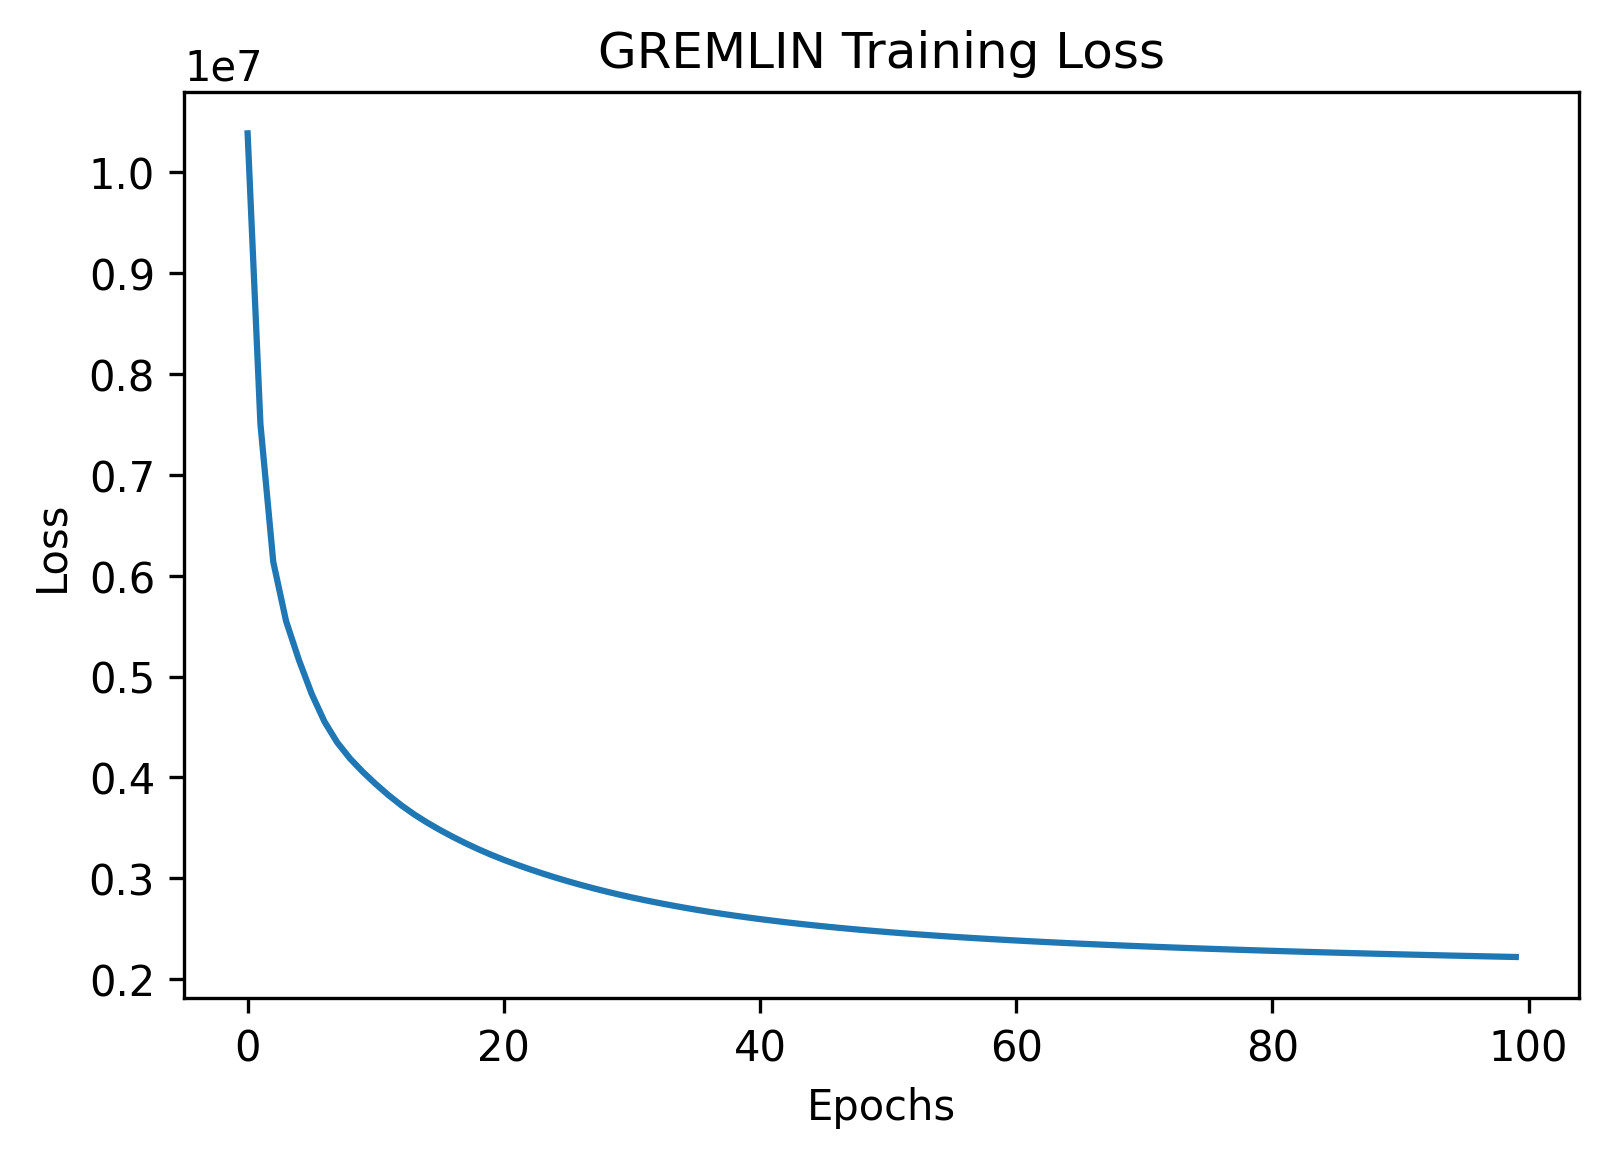

In [24]:
losses = []
for t in tq.tqdm(range(100)):
    loss = model(msa)      
    optimizer.zero_grad()    
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)
plt.title("GREMLIN Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [25]:
w = model.GREMLIN_.W0.cpu().detach().numpy()
w = (w+w.T).reshape(L,A,L,A)
h = model.GREMLIN_.b0.cpu().detach().numpy()
np.save("gremlin_h_lcc.npy", h)
np.save("gremlin_J_lcc.npy", w)


def get_mtx(W):
  # l2norm of 20x20 matrices (note: we ignore gaps)
  raw = np.sqrt(np.sum(np.square(W[:,:,:,:]),(1,3)))
  np.fill_diagonal(raw,0)
  # apc (average product correction)
  ap = np.sum(raw,0,keepdims=True)*np.sum(raw,1,keepdims=True)/np.sum(raw)
  apc = raw - ap
  np.fill_diagonal(apc,0)
  return(raw,apc)

In [26]:

def get_contacts(w, showContacts=True):
    """
    w:            (L, 21, L, 21) numpy array corresponding to the J parameter
    showContacts: When True, shows the couplings matrix before and after APC
    """
    raw, apc = get_mtx(w)
    raw_copy = np.copy(raw)
    apc_copy = np.copy(apc)
    for i in range(len(apc)):
        for j in range(len(apc)):
            if abs(i-j) < 7:
                apc_copy[i,j] = 0
                raw_copy[i,j] = 0
    if showContacts:
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(raw_copy)
        plt.grid(False)
        plt.title("Before APC")
        plt.xlabel("Residue Index")
        plt.ylabel("Residue Index")
        plt.subplot(1,2,2)
        plt.imshow(apc_copy)
        plt.xlabel("Residue Index")
        plt.grid(False)
        plt.title("After APC")
        plt.show()
    apc_copy = (apc_copy - np.min(apc_copy))/(np.max(apc_copy) - np.min(apc_copy))
    strengths = {}
    for i in range(len(apc)):
        for j in range(i, len(apc)):
            strengths[(i,j)] = apc_copy[i,j] 
    contacts = list(strengths.keys())
    contacts = sorted(contacts, key=lambda x: strengths[x], reverse=True)
    for i in range(len(contacts)):
        contacts[i] = list(contacts[i])
    L_2 = np.array(contacts[:int(len(apc) / 2)])    # @L/2
    L_5 = np.array(contacts[:int(len(apc) / 5)])    # @L/5
    return L_2, L_5

L2, L5 = get_contacts(w, showContacts=False)


In [27]:
model = Model(L,A).to(device)

h = model.GREMLIN_.b0.detach()
J = model.GREMLIN_.W0.detach()
J = (J + J.T)